# Домашнее задание 3. Алгоритмы кластеризации

In [254]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
import pyclustering

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Cчитываем данные, полученные в результате выполнения предыдущего домашнего задания, в `data frame` библиотеки `pandas`. Конвертируем данные в массив `numpy`.

In [255]:
data_df = pd.read_csv("hw2_out.csv", sep="\t", header=0, index_col="uid")
x = data_df.values

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего логина на портале Техносферы. При проверке домашнего задания бадут осуществляться проверка логина и соответствующего алгоритма.

In [256]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры  - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[hash("d.shevyakov") % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'OPTICS. (параметры - epsilon, min_pts)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [390]:
class optics_obj:    

    def __init__(self, index, core_distance = None, reachability_distance = None):
        self.index = index;
        self.core_distance = core_distance;
        self.reachability_distance = reachability_distance;
        self.processed = False;

from tqdm import tqdm
class Clustering:
    
      
    def process(self):
  
        for obj in tqdm(self.objects):
            if (obj.processed is False):
                self.__expand_cluster_order(obj);
 
    def get_clusters(self):
        return self.__clusters;
    
    def get_noise(self):
        return self.__noise;
    
    def get_cluster_ordering(self):
        ordering = [];
        for cluster in self.__clusters:
            for index_object in cluster:
                optics_object = self.objects[index_object];
                if (optics_object.reachability_distance is not None):
                    ordering.append(optics_object.reachability_distance);
        return ordering;
    
    def get_reachability_distances(self):
        reachability_distances = [obj.reachability_distance for obj in self.__ordered_database]
        reachability_distances = [obj if obj is not None else 0 for obj in reachability_distances]
        return reachability_distances
    
    def get_core_distances(self):
        core_distances = [obj.core_distance for obj in self.__ordered_database]
        core_distances = [obj if obj is not None else 0 for obj in core_distances]
        return core_distances
    
    def __distance (self, x, y):
        return np.sqrt(np.square(x-y).sum())
    

    
    def __expand_cluster_order(self, obj):

        obj.processed = True;
        
        neighbors = self.__neighbors(obj);
        obj.reachability_distance = None;
        
        self.__ordered_database.append(obj);
        
        # Check core distance
        if (len(neighbors) >= self.__min_pts):
            neighbors.sort(key = lambda obj: obj[1]);
            obj.core_distance = neighbors[self.__min_pts - 1][1];
            
            # Continue processing
            order_seed = list();
            self.__update_order_seed(obj, neighbors, order_seed);
            
            while(len(order_seed) > 0):
                optics_obj = order_seed[0];
                order_seed.remove(optics_obj);
                
                neighbors = self.__neighbors(optics_obj);
                optics_obj.processed = True;
                
                self.__ordered_database.append(optics_obj);
                
                if (len(neighbors) >= self.__min_pts):
                    neighbors.sort(key = lambda obj: obj[1]);
                    optics_obj.core_distance = neighbors[self.__min_pts - 1][1];
                    self.__update_order_seed(optics_obj, neighbors, order_seed);
                else:
                    optics_obj.core_distance = None;
        else:
            obj.core_distance = None;

    
    def __extract_clusters(self, eps):
     
        self.__clusters = [];
        self.__noise = [];

        current_cluster = [];
        for optics_object in self.__ordered_database:
            if ((optics_object.reachability_distance is None) or (optics_object.reachability_distance > eps)):
                if ((optics_object.core_distance is not None) and (optics_object.core_distance <= eps)):
                    if (len(current_cluster) > 0):
                        self.__clusters.append(current_cluster);
                        current_cluster = [];
                        
                    current_cluster.append(optics_object.index);
                else:
                    self.__noise.append(optics_object.index);
            else:
                current_cluster.append(optics_object.index);
        
        if (len(current_cluster) > 0):
            self.__clusters.append(current_cluster);
                
    def __update_order_seed(self, optics_obj, neighbors, order_seed):

        for neighbor in neighbors:
            neighbor_index = neighbor[0];
            current_reachable_distance = neighbor[1];
            
            if (self.objects[neighbor_index].processed != True):
                reachable_distance = max(current_reachable_distance, optics_obj.core_distance);
                if (self.objects[neighbor_index].reachability_distance is None):
                    self.objects[neighbor_index].reachability_distance = reachable_distance;
                    
                    # insert element in queue O(n) - worst case.
                    index_insertion = len(order_seed);
                    for index_seed in range(0, len(order_seed)):
                        if (reachable_distance < order_seed[index_seed].reachability_distance):
                            index_insertion = index_seed;
                            break;
                    
                    order_seed.insert(index_insertion, self.objects[neighbor_index]);

                else:
                    if (reachable_distance < self.objects[neighbor_index].reachability_distance):
                        self.objects[neighbor_index].reachability_distance = reachable_distance;
                        order_seed.sort(key = lambda obj: obj.reachability_distance);

    def __neighbors(self, optic_object):

        points = self.__kdtree.query_ball_point(self.__data[optic_object.index], self.__epsilon)
        points.remove(optic_object.index)         
        for index in xrange(len(points)):
            distance = self.__distance(self.__data[optic_object.index], self.__data[points[index]]);
            points[index] = [points[index], distance];
        return points
    
    def __init__(self, **kwargs):

        if ('epsilon' not in kwargs): raise Exception ("'epsilon' arguments is required")
        if ('min_pts' not in kwargs): raise Exception ("'min_pts' arguments is required")
        self.__epsilon = kwargs['epsilon']
        self.__min_pts = kwargs['min_pts']
        self.__ordered_list = [];
    
    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """
        self.__data = x
        self.__kdtree = ss.KDTree(x)
        self.x_len = len(x)
        self.objects = [optics_obj(i) for i in xrange(self.x_len)]
        self.__ordered_database = [];
        self.__clusters = None;    
        self.__noise = None; 

        self.process()
        return self

    
    def predict(self, x, eps=None):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        if eps is None: eps = self.__epsilon
        self.__extract_clusters(eps);
        prediction = [0]*self.x_len
        for cluster_num in xrange(len(self.__clusters)+1):
            if cluster_num == 0: continue
            for i in self.__clusters[cluster_num-1]:
                prediction[i] = cluster_num
        return prediction
    
    def fit_predict(self, x, y=None, eps=None):
        self.fit(x, y)
        return self.predict(x, eps=eps)

In [258]:
def draw_clusters(data, clusters, noise = [], marker_descr = '.', hide_axes = False, axes = None, display_result = True):
    """!
    @brief Displays clusters for data in 2D or 3D.
    
    @param[in] data (list): Points that are described by coordinates represented.
    @param[in] clusters (list): Clusters that are represented by lists of indexes where each index corresponds to point in data.
    @param[in] noise (list): Points that are regarded to noise.
    @param[in] marker_descr (string): Marker for displaying points.
    @param[in] hide_axes (bool): If True - axes is not displayed.
    @param[in] axes (ax) Matplotlib axes where clusters should be drawn, if it is not specified (None) then new plot will be created.
    @param[in] display_result (bool): If specified then matplotlib axes will be used for drawing and plot will not be shown.
    
    @return (ax) Matplotlib axes where drawn clusters are presented.
    
    """
    # Get dimension
    dimension = 0;
    if ( (data is not None) and (clusters is not None) ):
        dimension = len(data[0]);
    elif ( (data is None) and (clusters is not None) ):
        dimension = len(clusters[0][0]);
    else:
        raise NameError('Data or clusters should be specified exactly.');
    
    "Draw clusters"
    colors = [ 'red', 'blue', 'darkgreen', 'brown', 'violet', 
               'deepskyblue', 'darkgrey', 'lightsalmon', 'deeppink', 'yellow',
               'black', 'mediumspringgreen', 'orange', 'darkviolet', 'darkblue',
               'silver', 'lime', 'pink', 'gold', 'bisque' ];
               
    if (len(clusters) > len(colors)):
        raise NameError('Impossible to represent clusters due to number of specified colors.');
    
    fig = plt.figure();
    
    if (axes is None):
        # Check for dimensions
        if ((dimension) == 1 or (dimension == 2)):
            axes = fig.add_subplot(111);
        elif (dimension == 3):
            axes = fig.gca(projection='3d');
        else:
            raise NameError('Drawer supports only 2d and 3d data representation');
    
    color_index = 0;
    for cluster in clusters:
        color = colors[color_index];
        for item in cluster:
            if (dimension == 1):
                if (data is None):
                    axes.plot(item[0], 0.0, color = color, marker = marker_descr);
                else:
                    axes.plot(data[item][0], 0.0, color = color, marker = marker_descr);
            
            if (dimension == 2):
                if (data is None):
                    axes.plot(item[0], item[1], color = color, marker = marker_descr);
                else:
                    axes.plot(data[item][0], data[item][1], color = color, marker = marker_descr);
                    
            elif (dimension == 3):
                if (data is None):
                    axes.scatter(item[0], item[1], item[2], c = color, marker = marker_descr);
                else:
                    axes.scatter(data[item][0], data[item][1], data[item][2], c = color, marker = marker_descr);
        
        color_index += 1;
    
    for item in noise:
        if (dimension == 1):
            if (data is None):
                axes.plot(item[0], 0.0, 'w' + marker_descr);
            else:
                axes.plot(data[item][0], 0.0, 'w' + marker_descr);

        if (dimension == 2):
            if (data is None):
                axes.plot(item[0], item[1], 'w' + marker_descr);
            else:
                axes.plot(data[item][0], data[item][1], 'w' + marker_descr);
                
        elif (dimension == 3):
            if (data is None):
                axes.scatter(item[0], item[1], item[2], c = 'w', marker = marker_descr);
            else:
                axes.scatter(data[item][0], data[item][1], data[item][2], c = 'w', marker = marker_descr);
    
    axes.grid(True);
    
    if (hide_axes is True):
        axes.xaxis.set_ticklabels([]);
        axes.yaxis.set_ticklabels([]);
        
        if (dimension == 3):
            axes.zaxis.set_ticklabels([]);
    
    if (display_result is True):
        plt.show();

    return axes;

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

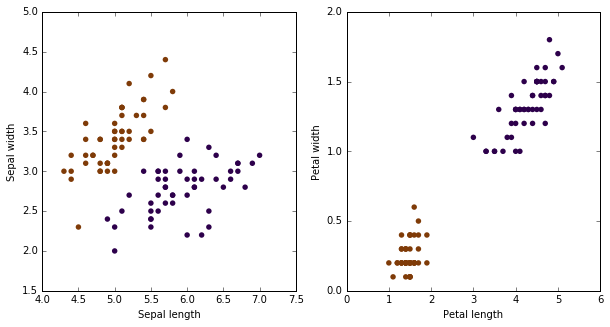

In [347]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

100%|██████████| 100/100 [00:00<00:00, 1676.55it/s]


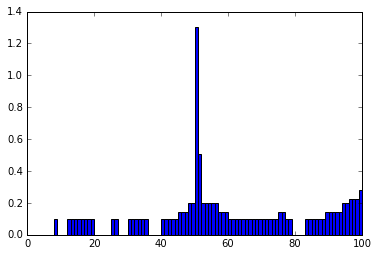

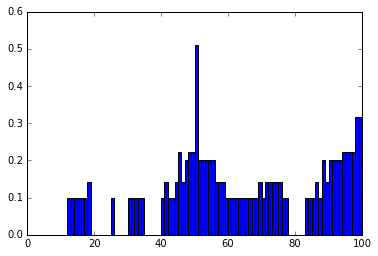

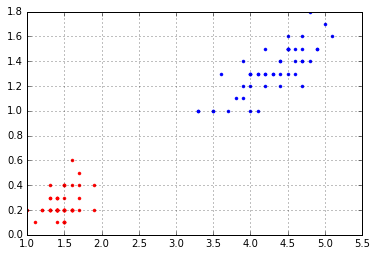

HELLO
[0, 1, 4, 8, 28, 33, 47, 49, 2, 36, 38, 42, 6, 17, 45, 40, 41, 12, 16, 3, 7, 10, 27, 39, 48, 19, 9, 32, 34, 37, 15, 21, 31, 14, 35, 11, 25, 29, 30, 46, 20, 18, 26, 5, 23, 43, 13, 22, 24, 44]

[0, 1, 4, 8, 28, 33, 47, 49, 2, 36, 38, 42, 6, 17, 45, 40, 41, 12, 16, 3, 7, 10, 27, 39, 48, 19, 9, 32, 34, 37, 15, 21, 31, 14, 35, 11, 25, 29, 30, 46, 20, 18, 26, 5, 23, 43, 13, 22, 24, 44, 50, 63, 76, 86, 56, 91, 54, 51, 66, 68, 78, 84, 85, 58, 55, 87, 65, 75, 90, 74, 97, 94, 96, 95, 88, 99, 53, 71, 89, 92, 82, 59, 69, 80, 81, 62, 52, 72, 73, 61, 67, 60, 79, 57, 93, 83, 77, 70, 64]

[0, 1, 4, 8, 28, 33, 47, 49, 2, 36, 38, 42, 6, 17, 45, 40, 41, 12, 16, 3, 7, 10, 27, 39, 48, 19, 9, 32, 34, 37, 15, 21, 31, 14, 35, 11, 25, 29, 30, 46, 20, 18, 26, 5, 23, 43, 13, 22, 24, 44, 50, 63, 76, 86, 56, 91, 54, 51, 66, 68, 78, 84, 85, 58, 55, 87, 65, 75, 90, 74, 97, 94, 96, 95, 88, 99, 53, 71, 89, 92, 82, 59, 69, 80, 81, 62, 52, 72, 73, 61, 67, 60, 79, 57, 93, 83, 77, 70, 64, 98]



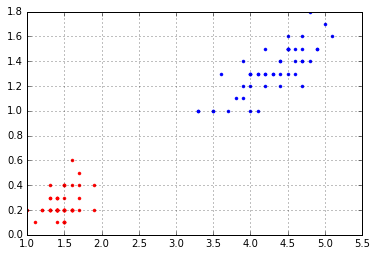

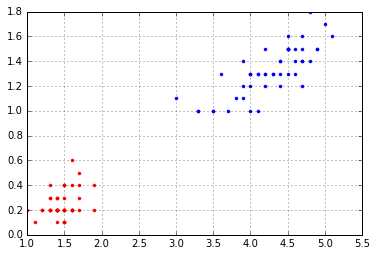

In [398]:


sample = x_iris[:,2:4]
eps = 0.3
mpts = 3

cl = Clustering(epsilon=10, min_pts=mpts).fit(sample)
iris_clusters = cl.predict(sample, eps=eps)

pl.bar(range(len(cl.get_reachability_distances())), cl.get_reachability_distances(), width=1)
pl.show()
pl.bar(range(len(cl.get_core_distances())), cl.get_core_distances(), width=1)
pl.show

draw_clusters(x_iris[:,2:4], cl.get_clusters(), cl.get_noise())

optics_instance = optics(sample, eps, mpts);
optics_instance.process();
  
draw_clusters(sample, optics_instance.get_clusters(), optics_instance.get_noise())    
    
op_clusters = optics_instance.get_clusters();
op_noise = optics_instance.get_noise();

db = sc.DBSCAN(eps=eps, min_samples=mpts).fit(sample)
db_clusters = []
for i in xrange(max(db.labels_)+1):
    db_clusters.append([])
for i in xrange(len(db.labels_)):
    db_clusters[db.labels_[i]].append(i)
draw_clusters(x_iris[:,2:4], db_clusters)

In [261]:
pred_iris = Clustering(epsilon=1, min_pts=3).fit_predict(x_iris)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

100%|██████████| 100/100 [00:00<00:00, 2003.93it/s]

Adjusted Rand index for iris is: 1.00


100%|██████████| 1000/1000 [00:05<00:00, 170.50it/s]


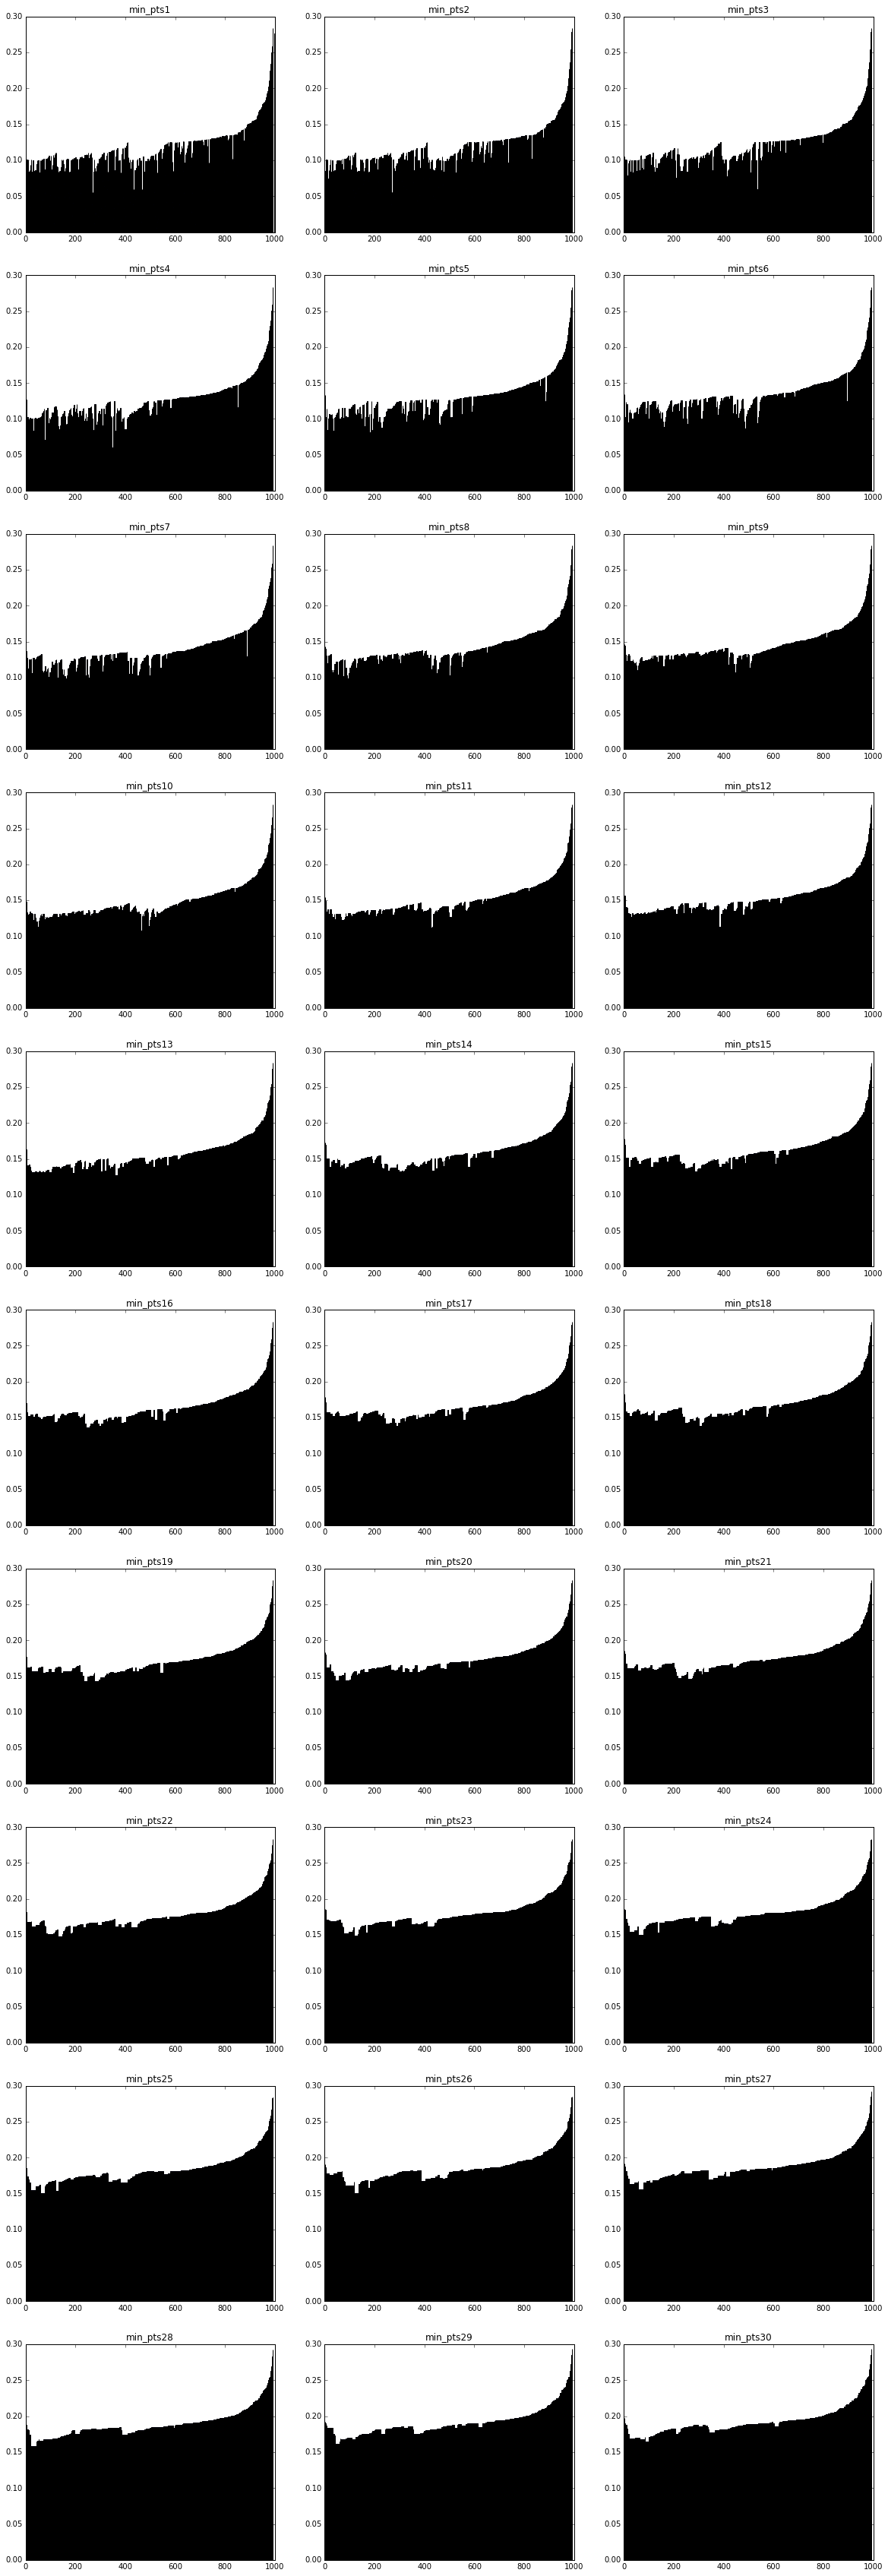

In [388]:
pl.figure(figsize=(20,60))

for mpts in xrange(1,31):
    twt = Clustering(epsilon=0.3, min_pts=mpts)
    twt.fit_predict(x[:1000])
    pl.subplot(10, 3, mpts)
    pl.title("min_pts"+str(mpts))
    pl.ylim([0,0.3])
    pl.bar(range(len(twt.get_reachability_distances())), twt.get_reachability_distances(), width=1)
pl.show()

Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [401]:
def average_dist(data, i, indices):
    return float(np.sum(np.sqrt(np.sum(np.square(data[indices] - data[i]), axis=1)))/(len(indices)-1))
    

def quality(x, y):
    """
    Silhouette
    """
    s = []
    for obj_num in xrange(len(y)):
        #exclude noise
        if y[obj_num] == 0: continue
        indices = [i for i in xrange(len(y)) if y[i] == y[obj_num]]
        a = average_dist(x, obj_num, indices)
        b = None
        for cluster in xrange(max(y)+1):
            #exclude noise
            if cluster == 0: continue
            if cluster == y[obj_num]: continue
            indices = [i for i in xrange(len(y)) if y[i] == cluster]
            new_b = average_dist(x, obj_num, indices)
            if (new_b < b) or (b is None): b = new_b
        if b is None or a is None or math.isnan(a) or math.isnan(b): continue
        s.append((b-a)/max(a, b))
    if len(s) > 0:
        score = float(sum(s)/len(s))
    else: 
        score = -1
    print score
    return score

In [402]:
#print x_iris[:,2:4]
print iris_clusters
quality(x_iris[:,2:4], iris_clusters)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2]
0.863696019089


0.8636960190890609

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

100%|██████████| 1000/1000 [00:02<00:00, 357.64it/s]


epsilon: 0.07 ; min_pts: 2 ; clusters: 50
0.777698850531
epsilon: 0.08 ; min_pts: 2 ; clusters: 58
0.723874319161
epsilon: 0.09 ; min_pts: 2 ; clusters: 80
0.537539897171
epsilon: 0.1 ; min_pts: 2 ; clusters: 94
0.427627369301
epsilon: 0.11 ; min_pts: 2 ; clusters: 45
0.030687494003
epsilon: 0.12 ; min_pts: 2 ; clusters: 40
-0.129252821407
epsilon: 0.13 ; min_pts: 2 ; clusters: 15
-0.129805635964
epsilon: 0.14 ; min_pts: 2 ; clusters: 4
-0.0597291372563
epsilon: 0.15 ; min_pts: 2 ; clusters: 2
0.264366618346
epsilon: 0.16 ; min_pts: 2 ; clusters: 2
0.398176348353
epsilon: 0.17 ; min_pts: 2 ; clusters: 3


  0%|          | 0/1000 [00:00<?, ?it/s]

0.200794342096
epsilon: 0.18 ; min_pts: 2 ; clusters: 1
-1


100%|██████████| 1000/1000 [00:02<00:00, 356.63it/s]


epsilon: 0.07 ; min_pts: 3 ; clusters: 12
0.828706673223
epsilon: 0.08 ; min_pts: 3 ; clusters: 16
0.779191917523
epsilon: 0.09 ; min_pts: 3 ; clusters: 39
0.582771848177
epsilon: 0.1 ; min_pts: 3 ; clusters: 44
0.466356338422
epsilon: 0.11 ; min_pts: 3 ; clusters: 26
0.0201646484323
epsilon: 0.12 ; min_pts: 3 ; clusters: 19
-0.185392678285
epsilon: 0.13 ; min_pts: 3 ; clusters: 11
-0.0785769420418
epsilon: 0.14 ; min_pts: 3 ; clusters: 6
0.00896608865796
epsilon: 0.15 ; min_pts: 3 ; clusters: 2
0.224311097572
epsilon: 0.16 ; min_pts: 3 ; clusters: 1
-1
epsilon: 0.17 ; min_pts: 3 ; clusters: 1
-1
epsilon: 0.18 ; min_pts: 3 ; clusters: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

-1


100%|██████████| 1000/1000 [00:02<00:00, 358.32it/s]


epsilon: 0.07 ; min_pts: 4 ; clusters: 2
0.866495923962
epsilon: 0.08 ; min_pts: 4 ; clusters: 5
0.871029632882
epsilon: 0.09 ; min_pts: 4 ; clusters: 20
0.661688792922
epsilon: 0.1 ; min_pts: 4 ; clusters: 24
0.575889617163
epsilon: 0.11 ; min_pts: 4 ; clusters: 30
0.243622667704
epsilon: 0.12 ; min_pts: 4 ; clusters: 16
-0.0618645602625
epsilon: 0.13 ; min_pts: 4 ; clusters: 8
-0.0426689476197
epsilon: 0.14 ; min_pts: 4 ; clusters: 6
-0.0668954557425
epsilon: 0.15 ; min_pts: 4 ; clusters: 2
0.252761542288
epsilon: 0.16 ; min_pts: 4 ; clusters: 1
-1
epsilon: 0.17 ; min_pts: 4 ; clusters: 1
-1
epsilon: 0.18 ; min_pts: 4 ; clusters: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

-1


100%|██████████| 1000/1000 [00:02<00:00, 358.81it/s]


epsilon: 0.07 ; min_pts: 5 ; clusters: 1
-1
epsilon: 0.08 ; min_pts: 5 ; clusters: 1
-1
epsilon: 0.09 ; min_pts: 5 ; clusters: 13
0.679695305594
epsilon: 0.1 ; min_pts: 5 ; clusters: 17
0.642511178888
epsilon: 0.11 ; min_pts: 5 ; clusters: 29
0.355956907927
epsilon: 0.12 ; min_pts: 5 ; clusters: 24
0.151555361423
epsilon: 0.13 ; min_pts: 5 ; clusters: 6
0.0564746010722
epsilon: 0.14 ; min_pts: 5 ; clusters: 5
0.00609566072021
epsilon: 0.15 ; min_pts: 5 ; clusters: 5
0.0224347621829
epsilon: 0.16 ; min_pts: 5 ; clusters: 1
-1
epsilon: 0.17 ; min_pts: 5 ; clusters: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

-1
epsilon: 0.18 ; min_pts: 5 ; clusters: 1
-1


100%|██████████| 1000/1000 [00:02<00:00, 364.30it/s]


epsilon: 0.07 ; min_pts: 6 ; clusters: 0
-1
epsilon: 0.08 ; min_pts: 6 ; clusters: 0
-1
epsilon: 0.09 ; min_pts: 6 ; clusters: 4
0.839454234061
epsilon: 0.1 ; min_pts: 6 ; clusters: 8
0.700369169105
epsilon: 0.11 ; min_pts: 6 ; clusters: 23
0.455670710394
epsilon: 0.12 ; min_pts: 6 ; clusters: 31
0.27100977493
epsilon: 0.13 ; min_pts: 6 ; clusters: 11
-0.00464931403673
epsilon: 0.14 ; min_pts: 6 ; clusters: 3
0.134577446528
epsilon: 0.15 ; min_pts: 6 ; clusters: 3
0.0988492708445
epsilon: 0.16 ; min_pts: 6 ; clusters: 2
0.273610901686
epsilon: 0.17 ; min_pts: 6 ; clusters: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

-1
epsilon: 0.18 ; min_pts: 6 ; clusters: 1
-1


100%|██████████| 1000/1000 [00:02<00:00, 362.53it/s]


epsilon: 0.07 ; min_pts: 7 ; clusters: 0
-1
epsilon: 0.08 ; min_pts: 7 ; clusters: 0
-1
epsilon: 0.09 ; min_pts: 7 ; clusters: 0
-1
epsilon: 0.1 ; min_pts: 7 ; clusters: 1
-1
epsilon: 0.11 ; min_pts: 7 ; clusters: 15
0.559747246522
epsilon: 0.12 ; min_pts: 7 ; clusters: 18
0.403752262202
epsilon: 0.13 ; min_pts: 7 ; clusters: 14
0.16012361736
epsilon: 0.14 ; min_pts: 7 ; clusters: 2
0.323718495014
epsilon: 0.15 ; min_pts: 7 ; clusters: 2
0.284695751787
epsilon: 0.16 ; min_pts: 7 ; clusters: 2
0.26478137058
epsilon: 0.17 ; min_pts: 7 ; clusters: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

-1
epsilon: 0.18 ; min_pts: 7 ; clusters: 1
-1


100%|██████████| 1000/1000 [00:02<00:00, 361.28it/s]


epsilon: 0.07 ; min_pts: 8 ; clusters: 0
-1
epsilon: 0.08 ; min_pts: 8 ; clusters: 0
-1
epsilon: 0.09 ; min_pts: 8 ; clusters: 0
-1
epsilon: 0.1 ; min_pts: 8 ; clusters: 1
-1
epsilon: 0.11 ; min_pts: 8 ; clusters: 7
0.583031694542
epsilon: 0.12 ; min_pts: 8 ; clusters: 16
0.478876243352
epsilon: 0.13 ; min_pts: 8 ; clusters: 15
0.255275231884
epsilon: 0.14 ; min_pts: 8 ; clusters: 2
0.220584093731
epsilon: 0.15 ; min_pts: 8 ; clusters: 1
-1
epsilon: 0.16 ; min_pts: 8 ; clusters: 2
0.568413476277
epsilon: 0.17 ; min_pts: 8 ; clusters: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

-1
epsilon: 0.18 ; min_pts: 8 ; clusters: 1
-1


100%|██████████| 1000/1000 [00:02<00:00, 363.84it/s]


epsilon: 0.07 ; min_pts: 9 ; clusters: 0
-1
epsilon: 0.08 ; min_pts: 9 ; clusters: 0
-1
epsilon: 0.09 ; min_pts: 9 ; clusters: 0
-1
epsilon: 0.1 ; min_pts: 9 ; clusters: 0
-1
epsilon: 0.11 ; min_pts: 9 ; clusters: 2
0.881133216482
epsilon: 0.12 ; min_pts: 9 ; clusters: 5
0.695398413656
epsilon: 0.13 ; min_pts: 9 ; clusters: 16
0.333363439706
epsilon: 0.14 ; min_pts: 9 ; clusters: 3
0.158674214664
epsilon: 0.15 ; min_pts: 9 ; clusters: 1
-1
epsilon: 0.16 ; min_pts: 9 ; clusters: 2
0.0635846142544
epsilon: 0.17 ; min_pts: 9 ; clusters: 1
-1
epsilon: 0.18 ; min_pts: 9 ; clusters: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

-1


100%|██████████| 1000/1000 [00:02<00:00, 365.26it/s]


epsilon: 0.07 ; min_pts: 10 ; clusters: 0
-1
epsilon: 0.08 ; min_pts: 10 ; clusters: 0
-1
epsilon: 0.09 ; min_pts: 10 ; clusters: 0
-1
epsilon: 0.1 ; min_pts: 10 ; clusters: 0
-1
epsilon: 0.11 ; min_pts: 10 ; clusters: 1
-1
epsilon: 0.12 ; min_pts: 10 ; clusters: 3
0.772081069692
epsilon: 0.13 ; min_pts: 10 ; clusters: 15
0.433445960945
epsilon: 0.14 ; min_pts: 10 ; clusters: 6
0.0908241917302
epsilon: 0.15 ; min_pts: 10 ; clusters: 2
0.156507327949
epsilon: 0.16 ; min_pts: 10 ; clusters: 1
-1
epsilon: 0.17 ; min_pts: 10 ; clusters: 1
-1
epsilon: 0.18 ; min_pts: 10 ; clusters: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

-1


100%|██████████| 1000/1000 [00:02<00:00, 364.70it/s]


epsilon: 0.07 ; min_pts: 11 ; clusters: 0
-1
epsilon: 0.08 ; min_pts: 11 ; clusters: 0
-1
epsilon: 0.09 ; min_pts: 11 ; clusters: 0
-1
epsilon: 0.1 ; min_pts: 11 ; clusters: 0
-1
epsilon: 0.11 ; min_pts: 11 ; clusters: 0
-1
epsilon: 0.12 ; min_pts: 11 ; clusters: 1
-1
epsilon: 0.13 ; min_pts: 11 ; clusters: 9
0.433899638822
epsilon: 0.14 ; min_pts: 11 ; clusters: 6
0.0752004019668
epsilon: 0.15 ; min_pts: 11 ; clusters: 3
0.107660739341
epsilon: 0.16 ; min_pts: 11 ; clusters: 1
-1
epsilon: 0.17 ; min_pts: 11 ; clusters: 1
-1
epsilon: 0.18 ; min_pts: 11 ; clusters: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

-1


100%|██████████| 1000/1000 [00:02<00:00, 362.63it/s]


epsilon: 0.07 ; min_pts: 12 ; clusters: 0
-1
epsilon: 0.08 ; min_pts: 12 ; clusters: 0
-1
epsilon: 0.09 ; min_pts: 12 ; clusters: 0
-1
epsilon: 0.1 ; min_pts: 12 ; clusters: 0
-1
epsilon: 0.11 ; min_pts: 12 ; clusters: 0
-1
epsilon: 0.12 ; min_pts: 12 ; clusters: 1
-1
epsilon: 0.13 ; min_pts: 12 ; clusters: 2
0.875314342526
epsilon: 0.14 ; min_pts: 12 ; clusters: 10
0.198005795734
epsilon: 0.15 ; min_pts: 12 ; clusters: 3
0.0179053852489
epsilon: 0.16 ; min_pts: 12 ; clusters: 1
-1
epsilon: 0.17 ; min_pts: 12 ; clusters: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

-1
epsilon: 0.18 ; min_pts: 12 ; clusters: 1
-1


100%|██████████| 1000/1000 [00:02<00:00, 357.77it/s]


epsilon: 0.07 ; min_pts: 13 ; clusters: 0
-1
epsilon: 0.08 ; min_pts: 13 ; clusters: 0
-1
epsilon: 0.09 ; min_pts: 13 ; clusters: 0
-1
epsilon: 0.1 ; min_pts: 13 ; clusters: 0
-1
epsilon: 0.11 ; min_pts: 13 ; clusters: 0
-1
epsilon: 0.12 ; min_pts: 13 ; clusters: 0
-1
epsilon: 0.13 ; min_pts: 13 ; clusters: 1
-1
epsilon: 0.14 ; min_pts: 13 ; clusters: 11
0.222928150358
epsilon: 0.15 ; min_pts: 13 ; clusters: 7
0.0795724550611
epsilon: 0.16 ; min_pts: 13 ; clusters: 1
-1
epsilon: 0.17 ; min_pts: 13 ; clusters: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

-1
epsilon: 0.18 ; min_pts: 13 ; clusters: 1
-1


100%|██████████| 1000/1000 [00:02<00:00, 355.83it/s]


epsilon: 0.07 ; min_pts: 14 ; clusters: 0
-1
epsilon: 0.08 ; min_pts: 14 ; clusters: 0
-1
epsilon: 0.09 ; min_pts: 14 ; clusters: 0
-1
epsilon: 0.1 ; min_pts: 14 ; clusters: 0
-1
epsilon: 0.11 ; min_pts: 14 ; clusters: 0
-1
epsilon: 0.12 ; min_pts: 14 ; clusters: 0
-1
epsilon: 0.13 ; min_pts: 14 ; clusters: 0
-1
epsilon: 0.14 ; min_pts: 14 ; clusters: 12
0.412456554514
epsilon: 0.15 ; min_pts: 14 ; clusters: 9
0.168731578755
epsilon: 0.16 ; min_pts: 14 ; clusters: 2
0.133275343398
epsilon: 0.17 ; min_pts: 14 ; clusters: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

-1
epsilon: 0.18 ; min_pts: 14 ; clusters: 1
-1


100%|██████████| 1000/1000 [00:02<00:00, 357.85it/s]


epsilon: 0.07 ; min_pts: 15 ; clusters: 0
-1
epsilon: 0.08 ; min_pts: 15 ; clusters: 0
-1
epsilon: 0.09 ; min_pts: 15 ; clusters: 0
-1
epsilon: 0.1 ; min_pts: 15 ; clusters: 0
-1
epsilon: 0.11 ; min_pts: 15 ; clusters: 0
-1
epsilon: 0.12 ; min_pts: 15 ; clusters: 0
-1
epsilon: 0.13 ; min_pts: 15 ; clusters: 0
-1
epsilon: 0.14 ; min_pts: 15 ; clusters: 6
0.51461909883
epsilon: 0.15 ; min_pts: 15 ; clusters: 9
0.210743535214
epsilon: 0.16 ; min_pts: 15 ; clusters: 3
0.0276427097203
epsilon: 0.17 ; min_pts: 15 ; clusters: 1
-1
epsilon: 0.18 ; min_pts: 15 ; clusters: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

-1


100%|██████████| 1000/1000 [00:02<00:00, 352.19it/s]


epsilon: 0.07 ; min_pts: 16 ; clusters: 0
-1
epsilon: 0.08 ; min_pts: 16 ; clusters: 0
-1
epsilon: 0.09 ; min_pts: 16 ; clusters: 0
-1
epsilon: 0.1 ; min_pts: 16 ; clusters: 0
-1
epsilon: 0.11 ; min_pts: 16 ; clusters: 0
-1
epsilon: 0.12 ; min_pts: 16 ; clusters: 0
-1
epsilon: 0.13 ; min_pts: 16 ; clusters: 0
-1
epsilon: 0.14 ; min_pts: 16 ; clusters: 2
0.558348073649
epsilon: 0.15 ; min_pts: 16 ; clusters: 10
0.311125653095
epsilon: 0.16 ; min_pts: 16 ; clusters: 5
-0.0562359132744
epsilon: 0.17 ; min_pts: 16 ; clusters: 1
-1
epsilon: 0.18 ; min_pts: 16 ; clusters: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

-1


100%|██████████| 1000/1000 [00:02<00:00, 347.34it/s]


epsilon: 0.07 ; min_pts: 17 ; clusters: 0
-1
epsilon: 0.08 ; min_pts: 17 ; clusters: 0
-1
epsilon: 0.09 ; min_pts: 17 ; clusters: 0
-1
epsilon: 0.1 ; min_pts: 17 ; clusters: 0
-1
epsilon: 0.11 ; min_pts: 17 ; clusters: 0
-1
epsilon: 0.12 ; min_pts: 17 ; clusters: 0
-1
epsilon: 0.13 ; min_pts: 17 ; clusters: 0
-1
epsilon: 0.14 ; min_pts: 17 ; clusters: 1
-1
epsilon: 0.15 ; min_pts: 17 ; clusters: 4
0.469637847104
epsilon: 0.16 ; min_pts: 17 ; clusters: 4
-0.0243640720675
epsilon: 0.17 ; min_pts: 17 ; clusters: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

-1
epsilon: 0.18 ; min_pts: 17 ; clusters: 1
-1


100%|██████████| 1000/1000 [00:02<00:00, 356.07it/s]


epsilon: 0.07 ; min_pts: 18 ; clusters: 0
-1
epsilon: 0.08 ; min_pts: 18 ; clusters: 0
-1
epsilon: 0.09 ; min_pts: 18 ; clusters: 0
-1
epsilon: 0.1 ; min_pts: 18 ; clusters: 0
-1
epsilon: 0.11 ; min_pts: 18 ; clusters: 0
-1
epsilon: 0.12 ; min_pts: 18 ; clusters: 0
-1
epsilon: 0.13 ; min_pts: 18 ; clusters: 0
-1
epsilon: 0.14 ; min_pts: 18 ; clusters: 1
-1
epsilon: 0.15 ; min_pts: 18 ; clusters: 3
0.350916559995
epsilon: 0.16 ; min_pts: 18 ; clusters: 5
0.189491390411
epsilon: 0.17 ; min_pts: 18 ; clusters: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

-1
epsilon: 0.18 ; min_pts: 18 ; clusters: 1
-1


100%|██████████| 1000/1000 [00:02<00:00, 365.42it/s]


epsilon: 0.07 ; min_pts: 19 ; clusters: 0
-1
epsilon: 0.08 ; min_pts: 19 ; clusters: 0
-1
epsilon: 0.09 ; min_pts: 19 ; clusters: 0
-1
epsilon: 0.1 ; min_pts: 19 ; clusters: 0
-1
epsilon: 0.11 ; min_pts: 19 ; clusters: 0
-1
epsilon: 0.12 ; min_pts: 19 ; clusters: 0
-1
epsilon: 0.13 ; min_pts: 19 ; clusters: 0
-1
epsilon: 0.14 ; min_pts: 19 ; clusters: 0
-1
epsilon: 0.15 ; min_pts: 19 ; clusters: 2
0.359016509473
epsilon: 0.16 ; min_pts: 19 ; clusters: 8
0.201081048853
epsilon: 0.17 ; min_pts: 19 ; clusters: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

-1
epsilon: 0.18 ; min_pts: 19 ; clusters: 1
-1


100%|██████████| 1000/1000 [00:02<00:00, 356.14it/s]


epsilon: 0.07 ; min_pts: 20 ; clusters: 0
-1
epsilon: 0.08 ; min_pts: 20 ; clusters: 0
-1
epsilon: 0.09 ; min_pts: 20 ; clusters: 0
-1
epsilon: 0.1 ; min_pts: 20 ; clusters: 0
-1
epsilon: 0.11 ; min_pts: 20 ; clusters: 0
-1
epsilon: 0.12 ; min_pts: 20 ; clusters: 0
-1
epsilon: 0.13 ; min_pts: 20 ; clusters: 0
-1
epsilon: 0.14 ; min_pts: 20 ; clusters: 0
-1
epsilon: 0.15 ; min_pts: 20 ; clusters: 2
0.631006684758
epsilon: 0.16 ; min_pts: 20 ; clusters: 7
0.301258913363
epsilon: 0.17 ; min_pts: 20 ; clusters: 2
0.115461837655
epsilon: 0.18 ; min_pts: 20 ; clusters: 1
-1


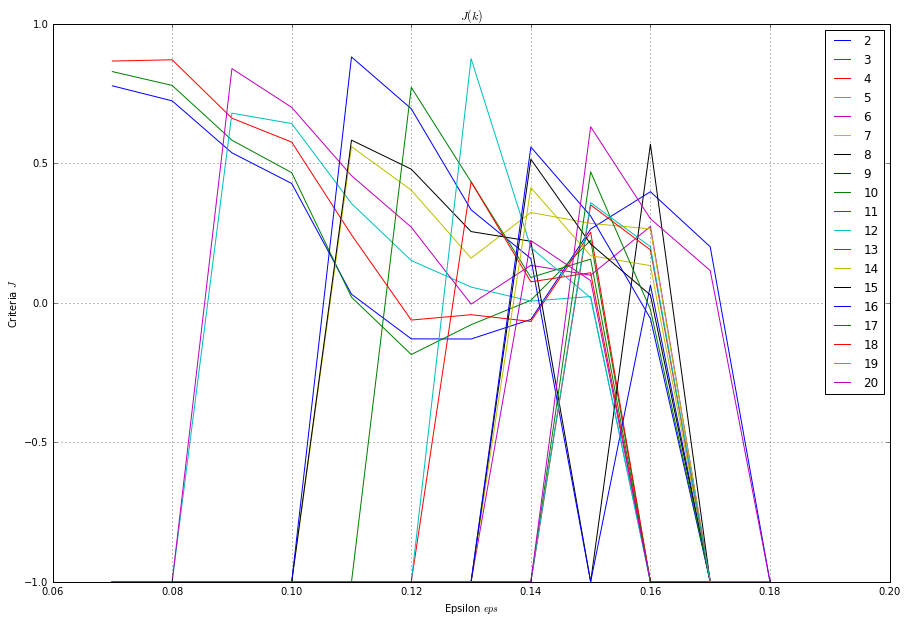

In [405]:
epsilons = [0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18]
min_ptss = range(2,21) #[2,3,4,5,6,7,8,9,10,11,12,30]
pl.figure(figsize=(15, 10))


for j,minpts in enumerate(min_ptss):
    criteria = np.zeros(len(epsilons))
    cls = Clustering(epsilon=max(epsilons), min_pts=minpts).fit(x[:1000])
    for i,eps in enumerate(epsilons):
        y = cls.predict(x[:1000], eps=eps)
        print 'epsilon:', eps, '; min_pts:', minpts, '; clusters:', max(y)
        criteria[i] = quality(x, y)
    pl.plot(epsilons, criteria, label=minpts)

pl.legend()
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Epsilon $eps$")
pl.grid()
pl.show()

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

In [408]:

cls = Clustering(epsilon=0.11, min_pts=9)
y = cls.fit_predict(x)

100%|██████████| 11242/11242 [01:24<00:00, 132.40it/s] 


Визуализируем результаты кластеризации ([подсказка](http://anokhin.github.io/img/hw3_tsne-kmeans.png)). Можно ли сказать, что в двумерном пространстве объекты из одного кластера находятся недалеко? Какой вывод можно сделать о качестве кластеризации?

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 11242
[t-SNE] Computed conditional probabilities for sample 2000 / 11242
[t-SNE] Computed conditional probabilities for sample 3000 / 11242
[t-SNE] Computed conditional probabilities for sample 4000 / 11242
[t-SNE] Computed conditional probabilities for sample 5000 / 11242
[t-SNE] Computed conditional probabilities for sample 6000 / 11242
[t-SNE] Computed conditional probabilities for sample 7000 / 11242
[t-SNE] Computed conditional probabilities for sample 8000 / 11242
[t-SNE] Computed conditional probabilities for sample 9000 / 11242
[t-SNE] Computed conditional probabilities for sample 10000 / 11242
[t-SNE] Computed conditional probabilities for sample 11000 / 11242
[t-SNE] Computed conditional probabilities for sample 11242 / 11242
[t-SNE] Mean sigma: 0.063858
[t-SNE] Error after 100 iterations with early exaggeration: 1.431275
[t-SNE] Error

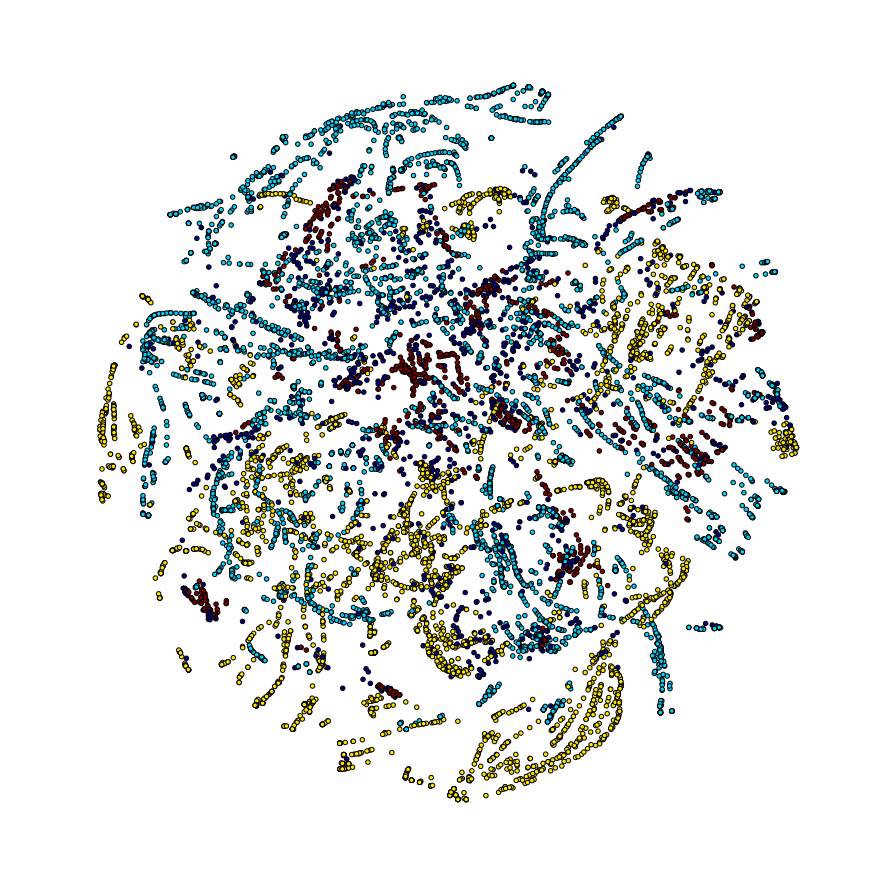

In [409]:
tsne = sm.TSNE(n_components=2, verbose=1, n_iter=1000)
z = tsne.fit_transform(x)

# Color map
cm = pl.get_cmap('jet')
pl.figure(figsize=(15, 15))
pl.scatter(z[:, 0], z[:, 1], c=map(lambda c: cm(1.0 * c / k), y))
pl.axis('off')
pl.show()

Попробуем проанализировать полученные кластеры. Для того, чтобы интерпретировать "суть" каждого из кластеров, построим [radar plot](http://www.wikiwand.com/en/Radar_chart), отображающий их центроиды. Посмотрите на графики и попробуйте объяснить, каким поведением можно охарактеризовать каждый из полученных кластеров? Есть ли среди кластеров похожие?

Реализация радара позаимствована отсюда: 
http://www.science-emergence.com/Matplotlib/MatplotlibGallery/RadarChartMatplotlibRougier/

[ 0  1  2  3  4  5  6  7  8  9 10]


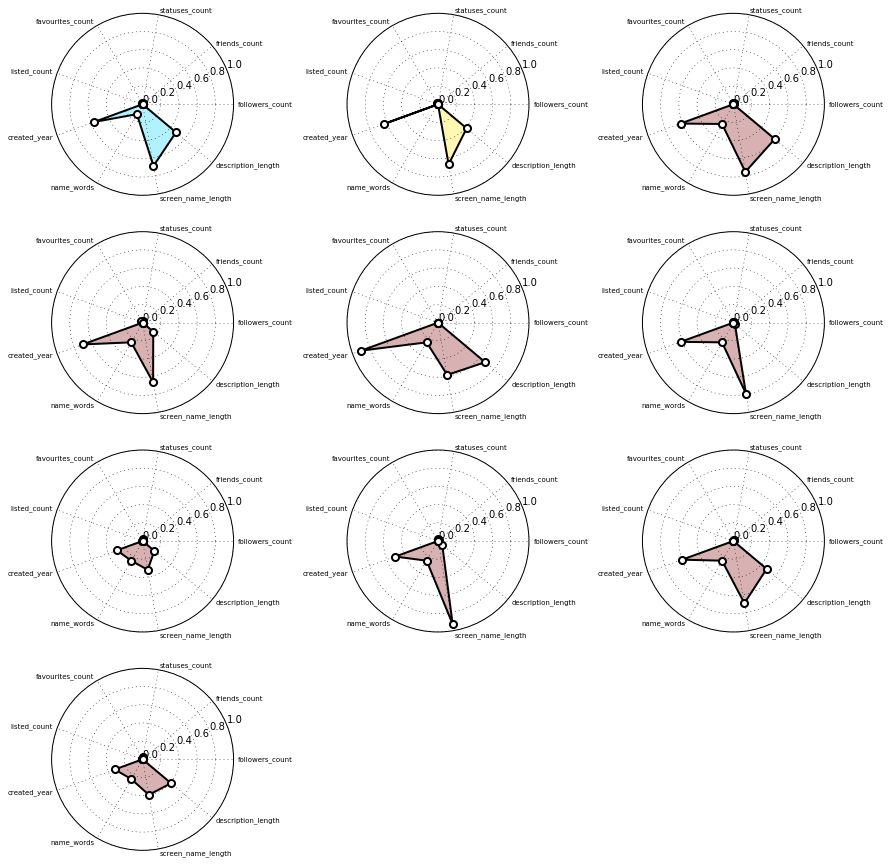

In [413]:
def radar(centroid, features, axes, color):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks(np.linspace(0, 1, 6))

    # Draw polygon representing centroid
    points = [(x, y) for x, y in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.3)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, 1)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'white')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(15, 15), facecolor='white')

cm = pl.get_cmap('jet')

clusters = np.unique(y)
print clusters
for j, cluster in enumerate(clusters):    
    if cluster == 0: continue
    x_c = x[y == cluster]
    centroid = x_c.mean(axis=0)    
    # Use a polar axes
    axes = plt.subplot(4, 3, j , polar=True)
    radar(centroid, data_df.columns.values, axes, cm(1.0 * j / k))

plt.show()

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.